In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

## Creating historical data csv from 10 tables

- Can ignore and just read in "historical_data_predictive_model.csv"
- Used regular and advanced season stats for the last 5 years

In [9]:
def process_year(year, champion_team):
    
    regular_df = pd.read_csv(f'reg_{year}.csv', header=1)
    regular_df = regular_df.rename(columns={'Unnamed: 1': 'Team'})
    advanced_df = pd.read_csv(f'adv_{year}.csv', header=1)
    advanced_df = advanced_df.rename(columns={'Unnamed: 1': 'Team'})

    data = pd.merge(advanced_df, regular_df, on='Team', suffixes=('_adv', '_reg'))

    data['Stanley_Cup_Champion'] = 0
    data.loc[data['Team'] == champion_team, 'Stanley_Cup_Champion'] = 1
    data['Year'] = year

    return data

In [61]:
years = range(2018, 2023)
champions = ['Washington Capitals*', 'St. Louis Blues*', 'Tampa Bay Lightning*', 'Tampa Bay Lightning*', 'Colorado Avalanche*']
historical_data = pd.concat([process_year(year, champion) for year, champion in zip(years, champions)], ignore_index=True)
historical_data

,Rk_adv,Team,S%_adv,SV%_adv,PDO,CF,CA,CF%,FF,FA,...,SHA,PIM/G,oPIM/G,S,S%_reg,SA,SV%_reg,SO,Stanley_Cup_Champion,Year
0,1,Nashville Predators*,7.6,0.939,101.6,3854,3629,51.5,2857,2689,...,5,11.3,9.6,2641,9.9,2659,0.923,11,0,2018
1,2,Winnipeg Jets*,7.9,0.931,101.0,3815,3590,51.5,2847,2657,...,7,8.5,8.6,2643,10.3,2613,0.917,7,0,2018
2,3,Tampa Bay Lightning*,8.6,0.934,102.0,3879,3640,51.6,2925,2762,...,3,9.2,9.5,2680,10.8,2683,0.913,8,0,2018
3,4,Boston Bruins*,7.3,0.929,100.2,3916,3373,53.7,2948,2532,...,10,9.5,9.6,2703,9.9,2399,0.912,4,0,2018
4,5,Vegas Golden Knights*,7.8,0.927,100.5,3885,3755,50.9,2884,2802,...,5,6.8,7.5,2686,10.0,2521,0.911,5,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,28,New Jersey Devils,8.0,0.905,98.6,3801,3734,50.4,2888,2874,...,14,8.1,8.4,2562,9.6,2540,0.881,2,0,2022
152,29,Philadelphia Flyers,7.6,0.919,99.5,3403,3895,46.6,2564,2921,...,11,9.0,9.0,2539,8.3,2785,0.894,1,0,2022
153,30,Seattle Kraken,7.5,0.908,98.3,3508,3415,50.7,2615,2593,...,7,8.5,8.0,2380,8.9,2367,0.880,3,0,2022
154,31,Arizona Coyotes,8.6,0.910,99.7,3118,3977,43.9,2346,3052,...,4,10.2,8.2,2121,9.7,2910,0.894,1,0,2022


In [62]:
historical_data.to_csv('historical_data_predictive_model.csv', index=False)

## Predictive Model

- Selection of random seed affects the prediction differently each time (42 outputs St. Louis)

In [63]:
random_seed = 42

data = historical_data
data = data.drop(columns=['Team'])

X = data.drop(columns=['Stanley_Cup_Champion'])
y = data['Stanley_Cup_Champion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

data_2022 = data[data['Year'] == 2022]
X_2022 = data_2022.drop(columns=['Stanley_Cup_Champion'])
team_probabilities = clf.predict_proba(X_2022)[:, 1]

top_5_indices = team_probabilities.argsort()[-5:][::-1]
top_5_teams = historical_data.loc[data_2022.index[top_5_indices], 'Team']
top_5_probabilities = team_probabilities[top_5_indices]

for team, prob in zip(top_5_teams, top_5_probabilities):
    print(f"{team}: {prob:.2%}")

predicted_champion = top_5_teams.iloc[0]
print(f"\nPredicted 2022 Stanley Cup Champion: {predicted_champion}")

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       0.00      0.00      0.00         1

    accuracy                           0.97        32
   macro avg       0.48      0.50      0.49        32
weighted avg       0.94      0.97      0.95        32

Accuracy: 0.96875
St. Louis Blues*: 16.00%
Nashville Predators*: 12.00%
Colorado Avalanche*: 9.00%
Minnesota Wild*: 8.00%
Tampa Bay Lightning*: 8.00%

Predicted 2022 Stanley Cup Champion: St. Louis Blues*


/Users/lukereath/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukereath/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lukereath/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Averaging multiple random seeds

- When averaging multiple random seeds the correct team is predicted

In [65]:
data = historical_data

teams = data['Team']

data = data.drop(columns=['Team'])

X = data.drop(columns=['Stanley_Cup_Champion'])
y = data['Stanley_Cup_Champion']

random_state_range = range(1, 200)

team_prob_dict = {}

for random_seed in random_state_range:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    clf.fit(X_train, y_train)

    data_2022 = data[data['Year'] == 2022]
    X_2022 = data_2022.drop(columns=['Stanley_Cup_Champion'])
    team_probabilities = clf.predict_proba(X_2022)[:, 1] 
    
    for team, prob in zip(teams[data_2022.index], team_probabilities):
        if team not in team_prob_dict:
            team_prob_dict[team] = [prob]
        else:
            team_prob_dict[team].append(prob)

for team in team_prob_dict:
    print(f"{team}: {np.mean(team_prob_dict[team]):.2%}")


Florida Panthers*: 14.89%
Colorado Avalanche*: 51.73%
Carolina Hurricanes*: 4.99%
Toronto Maple Leafs*: 5.83%
Minnesota Wild*: 9.41%
Calgary Flames*: 5.98%
Tampa Bay Lightning*: 6.57%
New York Rangers*: 3.15%
St. Louis Blues*: 10.37%
Boston Bruins*: 4.96%
Edmonton Oilers*: 1.27%
Pittsburgh Penguins*: 2.51%
Washington Capitals*: 0.67%
Los Angeles Kings*: 1.92%
Dallas Stars*: 0.52%
Nashville Predators*: 3.09%
Vegas Golden Knights: 0.82%
Vancouver Canucks: 0.51%
Winnipeg Jets: 1.31%
New York Islanders: 1.69%
Columbus Blue Jackets: 0.95%
San Jose Sharks: 0.06%
Anaheim Ducks: 0.12%
Buffalo Sabres: 0.02%
Detroit Red Wings: 0.04%
Ottawa Senators: 0.39%
Chicago Blackhawks: 0.04%
New Jersey Devils: 0.65%
Philadelphia Flyers: 0.13%
Seattle Kraken: 0.04%
Arizona Coyotes: 1.24%
Montreal Canadiens: 0.42%


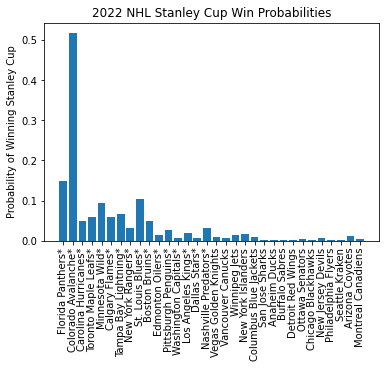

In [68]:
team_probs = [np.mean(team_prob_dict[team]) for team in team_prob_dict.keys()]
team_names = list(team_prob_dict.keys())

plt.bar(team_names, team_probs)
plt.xticks(rotation=90)
plt.ylabel('Probability of Winning Stanley Cup')
plt.title('2022 NHL Stanley Cup Win Probabilities')
plt.show()

## What attributes are most important

1. axDiff (0.067364) - Actual goal differential minus expected goal differential. A positive differential would indicate a team is converting or stopping an inordinate amount of good chances compared to league average. A negative differential would indicate a team is getting more good chances, but not converting or is allowing more than league norms.
2. HDCO% (0.040738) - Percentage of high-danger scoring chances that are converted to goals, for this team's opponents
3. CA (0.040561) - Corsi Against at 5 on 5 (Shots + Blocks + Misses)
4. PP (0.039168) - Power Play Goals
5. HDF% (0.034204) - Percentage of high-danger scoring chances in this team's favor

In [66]:
historical_data.columns

Index(['Rk_adv', 'Team', 'S%_adv', 'SV%_adv', 'PDO', 'CF', 'CA', 'CF%', 'FF',
       'FA', 'FF%', 'xGF', 'xGA', 'aGF', 'aGA', 'axDiff', 'SCF', 'SCA', 'SCF%',
       'HDF', 'HDA', 'HDF%', 'HDGF', 'HDC%', 'HDGA', 'HDCO%', 'Rk_reg',
       'AvAge', 'GP', 'W', 'L', 'OL', 'PTS', 'PTS%', 'GF', 'GA', 'SOW', 'SOL',
       'SRS', 'SOS', 'GF/G', 'GA/G', 'PP', 'PPO', 'PP%', 'PPA', 'PPOA', 'PK%',
       'SH', 'SHA', 'PIM/G', 'oPIM/G', 'S', 'S%_reg', 'SA', 'SV%_reg', 'SO',
       'Stanley_Cup_Champion', 'Year'],
      dtype='object')

In [67]:
importance = clf.feature_importances_
indices = np.argsort(importance)[::-1]
feature_names = X.columns

print("Top 10 Most Important Predictors:")
for f in range(10):
    print("%d. %s (%f)" % (f+1, feature_names[indices[f]], importance[indices[f]]))


Top 10 Most Important Predictors:
1. axDiff (0.067364)
2. HDCO% (0.040738)
3. CA (0.040561)
4. PP (0.039168)
5. HDF% (0.034204)
6. SRS (0.033044)
7. S%_reg (0.031423)
8. W (0.026837)
9. FA (0.026136)
10. SV%_adv (0.025618)
